# Apply Embedding on Realizing High Throughput Binding Assay Dataset with RNA Structure
## Import packages

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline

## Import Data

In [4]:
df = pd.read_csv("Result_Structure.csv")
df.head()

Sequence                    Structure   MFE         K  \
0  GGAUCCAUUCAAAAAAAGAACGGAUCC  ((((((.(((.......))).)))))) -10.5  4.971544   
1  GGAUCCAUUCAAAAAACGAACGGAUCC  ((((((.(((.......))).)))))) -10.5  4.514383   
2  GGAUCCAUUCAAAAAAGGAACGGAUCC  ((((((.(((.......))).)))))) -10.4  3.609146   
3  GGAUCCAUUCAAAAAAUGAACGGAUCC  ((((((.((((.....)))).)))))) -11.7  6.607685   
4  GGAUCCAUUCAAAAACAGAACGGAUCC  ((((((.(((.......))).)))))) -10.5  3.221327   

         KA       RKA  Qc sevenMer  
0  0.201145  0.395847   0  AAAAAAA  
1  0.221514  0.435934   0  AAAAAAC  
2  0.277074  0.545273   0  AAAAAAG  
3  0.151339  0.297831   0  AAAAAAU  
4  0.310431  0.610919   0  AAAAACA

In [5]:
def cutWord(x, window=2):
    seq2word = []
    for i in range(13):
        seq2word.append(x[i*window:i*window+window])
    return " ".join(seq2word)

## Prepare Data for Training


<AxesSubplot:ylabel='Count'>

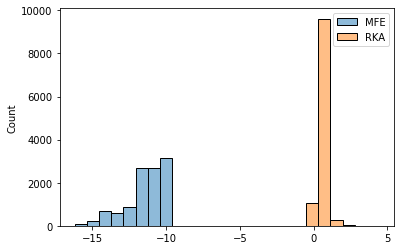

In [6]:
target = df[['MFE','RKA']].copy()
sequences = df[["Sequence"]].copy()
#seq_spaced = sequences.applymap(" ".join)
seq_spaced = sequences.applymap(cutWord)
X_train, X_test, y_train, y_test = train_test_split(seq_spaced, target, test_size=0.33, random_state=42)

# Divide to train and test

#mm = make_pipeline(MinMaxScaler(), Normalizer())
#y_train = mm.fit_transform(y_train)
#y_test = mm.transform(y_test)

#Use seaborn to check the data
sns.histplot(y_train)

In [7]:
X_train

Sequence
8136   GG AU CC AU UC CU UU AG AG AA CG GA UC
14307  GG AU CC AU UC UC UU GA UG AA CG GA UC
13839  GG AU CC AU UC UC GA AU UG AA CG GA UC
6922   GG AU CC AU UC CG UA AG GG AA CG GA UC
2422   GG AU CC AU UC AG CC UC GG AA CG GA UC
...                                       ...
13418  GG AU CC AU UC UC AC GG GG AA CG GA UC
5390   GG AU CC AU UC CC CA AU GG AA CG GA UC
860    GG AU CC AU UC AA UC CU AG AA CG GA UC
15795  GG AU CC AU UC UU CG UA UG AA CG GA UC
7270   GG AU CC AU UC CU AC GC GG AA CG GA UC

[10977 rows x 1 columns]

### Insert space between each nucleotide

### Convert pandas dataframe to tensorflow dataset

In [8]:
#Training data
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
#data_tf.shuffle(60)

Metal device set to: AMD Radeon Pro 560X


2022-01-08 17:13:44.675084: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-08 17:13:44.675622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-08 17:13:44.675866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Sequence Vectorization

In [9]:
#Text vectorize
sequence_database = tf.data.Dataset.from_tensor_slices(X_train)
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=16, output_mode='int', output_sequence_length=13, name ='vectorize_layer')
vectorize_layer.adapt(seq_spaced)

2022-01-08 17:13:45.563946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [10]:
embedding_layer = tf.keras.layers.Embedding(input_dim=16, output_dim=2, name = 'embedding_layer')


In [11]:

def model_gen():
    input = tf.keras.Input(shape=(1,), dtype='string')
    x = vectorize_layer(input)
    x = embedding_layer(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    output = tf.keras.layers.Dense(2)(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    return(model)

In [12]:
model=model_gen()
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


In [13]:
model.fit(
    data_train,
    validation_data=data_test,
    epochs=4
    #callbacks=[tensorboard_callback]
    )


Epoch 1/4


2022-01-08 17:13:47.070373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10975/10977 [============================>.] - ETA: 0s - loss: 36.9915 - accuracy: 4.5558e-05

2022-01-08 17:16:36.262605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10977/10977 [==============================] - 192s 17ms/step - loss: 36.9926 - accuracy: 4.5550e-05 - val_loss: 36.4207 - val_accuracy: 0.0000e+00
Epoch 2/4
10977/10977 [==============================] - 190s 17ms/step - loss: 36.4274 - accuracy: 0.0000e+00 - val_loss: 36.4176 - val_accuracy: 0.0000e+00
Epoch 3/4
10977/10977 [==============================] - 191s 17ms/step - loss: 36.4265 - accuracy: 0.0000e+00 - val_loss: 36.4170 - val_accuracy: 0.0000e+00
Epoch 4/4
10977/10977 [==============================] - 193s 18ms/step - loss: 36.4263 - accuracy: 0.0000e+00 - val_loss: 36.4168 - val_accuracy: 0.0000e+00


In [14]:
model.summary()
layer1 = model.get_layer('vectorize_layer')
layer2 = model.get_layer('embedding_layer')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 vectorize_layer (TextVector  (None, 13)               0         
 ization)                                                        
                                                                 
 embedding_layer (Embedding)  (None, 13, 2)            32        
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 2)                 34    

In [15]:

P = layer1(seq_spaced)
P = layer2(P)
P
#P = tf.squeeze(P)
P = P.numpy()

In [16]:
P[:,1,1]

array([-0.27644774, -0.27644774, -0.27644774, ..., -0.27644774,
       -0.27644774, -0.27644774], dtype=float32)

In [17]:
df_cp = df.copy()
for i in range(13):
    for j in range(2):
        df_cp["L"+str(i+1)+str(j+1)] = P[:,i,j]

In [18]:
df_cp.head()

Sequence                    Structure   MFE         K  \
0  GGAUCCAUUCAAAAAAAGAACGGAUCC  ((((((.(((.......))).)))))) -10.5  4.971544   
1  GGAUCCAUUCAAAAAACGAACGGAUCC  ((((((.(((.......))).)))))) -10.5  4.514383   
2  GGAUCCAUUCAAAAAAGGAACGGAUCC  ((((((.(((.......))).)))))) -10.4  3.609146   
3  GGAUCCAUUCAAAAAAUGAACGGAUCC  ((((((.((((.....)))).)))))) -11.7  6.607685   
4  GGAUCCAUUCAAAAACAGAACGGAUCC  ((((((.(((.......))).)))))) -10.5  3.221327   

         KA       RKA  Qc sevenMer       L11       L12  ...       L91  \
0  0.201145  0.395847   0  AAAAAAA  0.991647 -0.937372  ...  0.195342   
1  0.221514  0.435934   0  AAAAAAC  0.991647 -0.937372  ...  0.407735   
2  0.277074  0.545273   0  AAAAAAG  0.991647 -0.937372  ...  0.991647   
3  0.151339  0.297831   0  AAAAAAU  0.991647 -0.937372  ...  0.492432   
4  0.310431  0.610919   0  AAAAACA  0.991647 -0.937372  ...  0.195342   

        L92      L101      L102      L111      L112      L121     L122  \
0 -0.198795  0.223116 -0.246934  0.407735 -0.485398  0.532031 -0.49553   
1 -0.485398  0.223116 -0.246934  0.407735 -0.485398  0.532031 -0.49553   
2 -0.937372  0.223116 -0.246934  0.407735 -0.485398  0.532031 -0.49553   
3 -0.485741  0.223116 -0.246934  0.407735 -0.485398  0.532031 -0.49553   
4 -0.198795  0.223116 -0.246934  0.407735 -0.485398  0.532031 -0.49553   

       L131      L132  
0  0.441737 -0.397173  
1  0.441737 -0.397173  
2  0.441737 -0.397173  
3  0.441737 -0.397173  
4  0.441737 -0.397173  

[5 rows x 34 columns]

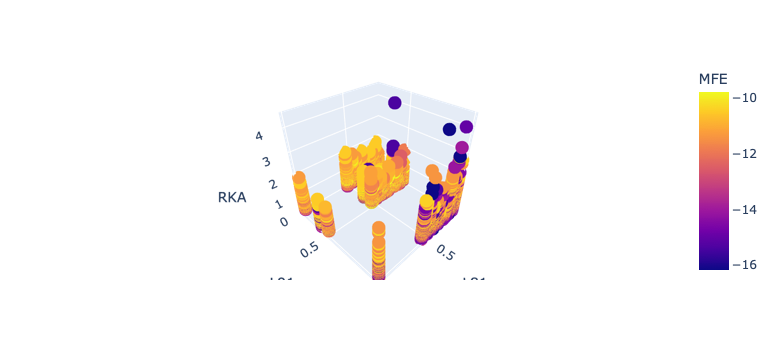

In [33]:
import plotly.express as px
df = df_cp
fig = px.scatter_3d(df, x='L81', y='L91', z='RKA', color='MFE',
                   custom_data=['sevenMer', 'RKA', 'MFE'])
#set hover
fig.update_traces(
    hovertemplate = "<br>".join([
    "%{sevenMer}",
    "MFE: %{MFE}",
    "RKA: %{RKA}"])
)

fig.show()

<AxesSubplot:xlabel='L91', ylabel='RKA'>

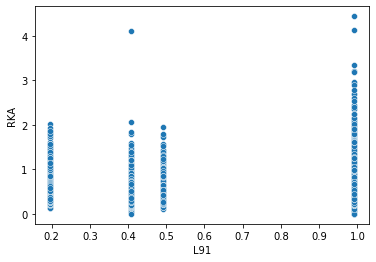

In [20]:
sns.scatterplot(data=df_cp, x='L91', y='RKA')

## Apply t-SNE to visualize the groups

In [21]:
from sklearn.manifold import TSNE

#data for t-SNE
df_tsne = df_cp.copy()
df_tsne = df_tsne.drop(["Sequence", "Structure", "K", "KA", "Qc", "sevenMer"], axis = 1)

In [22]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_tsne)

/Users/fatmimi/tensorflow-metal/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

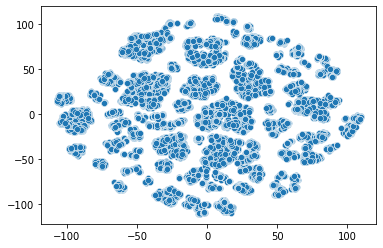

In [23]:
sns.scatterplot(X_embedded[:,0],X_embedded[:,1])

<AxesSubplot:xlabel='MFE', ylabel='RKA'>

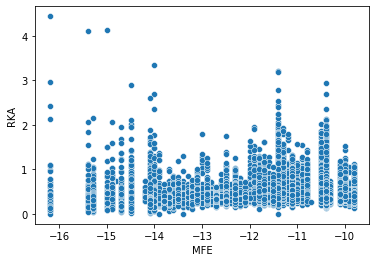

In [24]:
sns.scatterplot(data=df, x='MFE', y='RKA')

In [25]:
df_key = df_cp[["MFE","RKA","L71", "L81", "L91"]] 
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=50).fit_transform(df_key)
df_visual = pd.DataFrame(X_embedded)
df_visual.head()

0          1          2
0 -10.006973   4.152011  24.405663
1   3.435213  -1.606859   7.231433
2 -16.933331  20.945845  -8.234149
3  19.183109  11.502058   0.572211
4  -9.849315   1.364159  24.069693

In [26]:
df_visual["RKA"] = df_key.RKA
df_visual.columns = ["x", "y", "z", "RKA"]

In [27]:
import plotly.express as px
df = df_cp
fig = px.scatter_3d(df_visual, x='x', y='y', z='z', color="RKA", size_max=0.5)
fig.show

<bound method BaseFigure.show of Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<br>z=%{z}<br>RKA=%{marker.color}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': array([0.39584708, 0.43593353, 0.54527327, ..., 0.3658341 , 0.447969  ,
                                         0.26066637]),
                         'coloraxis': 'coloraxis',
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'scene': 'scene',
              'showlegend': False,
              'type': 'scatter3d',
              'x': array([-10.006973 ,   3.4352126, -16.93333  , ...,   8.5173855, -11.189626 ,
                           10.20621  ], dtype=float32),
              'y': array([  4.152011 ,  -1.6068586,  20.945845 , ..., -12.86246  ,  -4.570977 ,
                           15.161968 ], dtype=float32),
              'z': array([ 24.405663 ,   7.231433 ,  -8.234149 , ...,   4.7012973, -16.605593 ,
       